In [6]:
!pip install alpaca-py

  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.2
    Uninstalling msgpack-1.0.2:
      Successfully uninstalled msgpack-1.0.2


In [17]:
import pandas as pd
import numpy as np
from alpaca.data import TimeFrame, StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
key = 'PK2K9D3EBSR2WGWTA5NM'
secret = 'CWjVKR6LeIw4va1HoM3e3zXPBCry9OupSgfOuKWN'

api = client = StockHistoricalDataClient(key, secret)
request_params = StockBarsRequest(
                        symbol_or_symbols=['AAPL'],
                        timeframe=TimeFrame.Day,
                        start="2018-01-01 00:00:00"
                 )
bars = api.get_stock_bars(request_params)

In [10]:
df = bars.df[['open', 'high', 'low', 'close', 'volume']]

In [337]:
simbols = pd.read_csv('symbols_pnd.csv')
pump_data = pd.read_csv('pump_data.csv')

In [351]:
pump_data.head()

,symbol,date,valid
0,AAME,2017-05-12,0
1,AACG,2020-07-05,0
2,MWA,2019-10-20,0
3,ACRS,2021-06-12,0
4,BKYI,2020-02-13,0


In [352]:
pump_data.tail()

,symbol,date,valid
2343,JOAN,2021-03-09,1
2344,PEY,2019-09-12,1
2345,DNOW,2021-04-25,1
2346,BCYP,2018-07-21,1
2347,SVAC,2019-12-10,1


In [353]:
simb = simbols['0'].values

In [367]:
import datetime 

target_data = pd.DataFrame()
for r in pump_data:
    r = r[1]
    request_params = StockBarsRequest(
                            symbol_or_symbols=list(simb),
                            timeframe=TimeFrame.Day,
                            start=datetime.datetime(r['date']) - datetime.timedelta(day=22),
                            end=datetime.datetime(r['date']) - datetime.timedelta(day=1)
                        
                     )
    bars = api.get_stock_bars(request_params)
    df = bars.df.reset_index(level=0)
    target_data = pd.concat([target_data, df], axis=0)
    
before_data = pd.DataFrame()
for r in pump_data:
    r = r[1]
    request_params = StockBarsRequest(
                            symbol_or_symbols=list(r['symbol']),
                            timeframe=TimeFrame.Day,
                            start=datetime.datetime(r['date']) - datetime.timedelta(day=23),
                            end=datetime.datetime(r['date']) - datetime.timedelta(day=2)
                        
                     )
    bars = api.get_stock_bars(request_params)
    df = bars.df.reset_index(level=0)
    before_data = pd.concat([before_data, df], axis=0)
    

request_params = StockBarsRequest(
                        symbol_or_symbols=list(symb),
                        timeframe=TimeFrame.Day,
                        start='2022-01-01'
                 )
bars = api.get_stock_bars(request_params)
df = bars.df.reset_index(level=0)

In [394]:
def res_data(data):
    data = bars.df[['open', 'high', 'low', 'close', 'volume']]
    data = data.groupby('symbol').apply(lambda x: x.diff()).dropna()
    data_reshaped = data.groupby('symbol').apply(reshape_data)
    return data_reshaped

In [402]:
target_data_reshaped = res_data(target_data)
target_data_reshaped['target'] = 1
target_data_reshaped = target_data_reshaped.merge(pump_data[['symbol', 'valid']], on='symbol')
before_data_reshaped = res_data(before_data)
before_data_reshaped['target'] = 0
df_reshaped = res_data(df)
df_reshaped['target'] = 0

data_reshaped = pd.concat([df_reshaped, before_data_reshaped, target_data_reshaped], axis=0)
data_reshaped['valid'].fillna(-1, inplace=True)
price_data = data_reshaped.index()
data_reshaped.reset_index(drop=True, inplace=True)
data_reshaped = data_reshaped.dropna()
print(data_reshaped.shape)
data_reshaped.head()

(25734, 102)


,open_0,open_1,open_2,open_3,open_4,open_5,open_6,open_7,open_8,open_9,...,volume_12,volume_13,volume_14,volume_15,volume_16,volume_17,volume_18,volume_19,target,valid
0,-0.06,0.02,0.08,0.04,0.06,-0.0700,0.0600,0.0900,0.0700,-0.0738,...,-33256.0,1026540.0,-1009825.0,-2398.0,43804.0,-57586.0,-5155.0,4251.0,0.0,-1
1,0.02,0.08,0.04,0.06,-0.07,0.0600,0.0900,0.0700,-0.0738,-0.0262,...,1026540.0,-1009825.0,-2398.0,43804.0,-57586.0,-5155.0,4251.0,7793.0,0.0,-1
2,0.08,0.04,0.06,-0.07,0.06,0.0900,0.0700,-0.0738,-0.0262,0.0100,...,-1009825.0,-2398.0,43804.0,-57586.0,-5155.0,4251.0,7793.0,2200398.0,0.0,-1
3,0.04,0.06,-0.07,0.06,0.09,0.0700,-0.0738,-0.0262,0.0100,-0.1300,...,-2398.0,43804.0,-57586.0,-5155.0,4251.0,7793.0,2200398.0,-2213050.0,0.0,-1
4,0.06,-0.07,0.06,0.09,0.07,-0.0738,-0.0262,0.0100,-0.1300,0.0700,...,43804.0,-57586.0,-5155.0,4251.0,7793.0,2200398.0,-2213050.0,16372.0,0.0,-1


In [416]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

validate = data_reshaped[data_reshaped['valid'] == 1]
data_reshaped.drop('valid', axis=1)

X = data_reshaped[data_reshaped['valid'] != 1].drop(['target', 'valid'], axis=1)
y = data_reshaped[data_reshaped['valid'] != 1]['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


scaler = StandardScaler()
v = X_train[[i for i in X_train.columns if 'volume' in i]]
X_train[[i for i in X_train.columns if 'volume' in i]] = scaler.fit_transform(v)
X_test[[i for i in X_test.columns if 'volume' in i]] = scaler.transform(X_test[[i for i in X_test.columns if 'volume' in i]])
validate[[i for i in validate.columns if 'volume' in i]] = scaler.transform(validate[[i for i in validate.columns if 'volume' in i]])

In [420]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

pred = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, pred)

0.6503742417395917

In [422]:
log_loss(y_test, pred)

0.449786854869675

In [432]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(n_estimators=500, class_weight={0:0.2, 1:0.8})
model.fit(X_train, y_train)

pred = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, pred)

0.801262470747629

In [433]:
log_loss(y_test, pred)

0.351495697065058

In [441]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
import seaborn as sns

precision, recall, thresholds = precision_recall_curve(y_testt, pred)
beta = 0.5
fscore = (1 + beta ** 2) * (2 * precision * recall) / (beta ** 2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))


sns.set(rc={"figure.figsize":(14,8)})
display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="LightGBM"
)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label=f'Порог отсечения {round(thresholds[ix],2)}')
_ = display.ax_.set_title("Кривая Precision-Recall")

NameError: name 'y_testt' is not defined

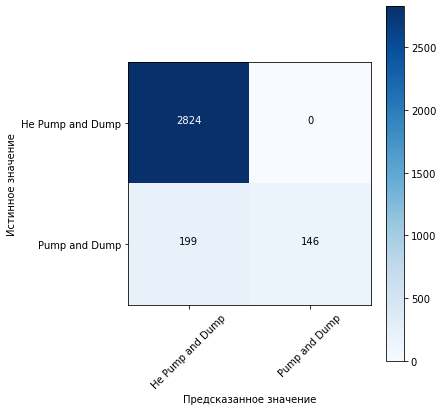

In [442]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинное значение')
    plt.xlabel('Предсказанное значение')
#     plt.savefig(f'img/test_n_days/{title}.png')



def show(y_test, y_pred_proba, threshold):
    data_threshold = (y_pred_proba > threshold)    
    cm = confusion_matrix(y_test, data_threshold)
    minus_recall = round(cm[0][0] / cm.sum(axis=0)[0], 2)
    plot_confusion_matrix(cm, classes=['Не Pump and Dump', 'Pump and Dump'], title=f'')


show(y_test, pred, 0.3)

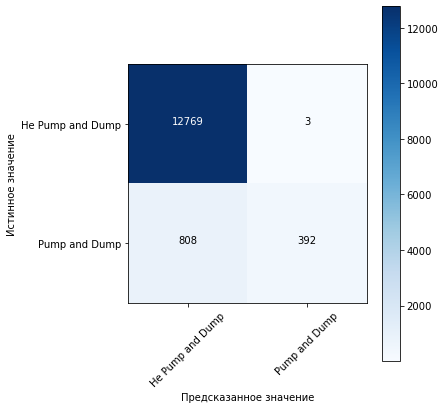

In [443]:
show(test_test_y, pred_val, 0.2)

In [444]:
392/(392+3)

0.9924050632911392